# Create HAdamard encoding 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS


# For simulation, create a random parent amino acid sequence to create SOLD libraries from

This is an example of a fully in silico path to test and understand the simulator. The functions in the simulator are written such that we can develop models from a given SOLD matrix.
Deep mutational scan at multiple locaitons also conform to the SOLD matrix abstraction 

## Pretend that a set of positions in the protein is mutated--create a sythesis SOLD matrix

In [2]:
length_of_protein = 100
num_mutated = 5
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, mut_probs = [0.1, 0.1, 0.1, 0.1], parent_prob=0.60) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 
    

Parent protein: FMIEAEEATQGFGIHNNHMHGVCMTMVTSCLICTKLRKVSRSDDNAPQTNDNIDKTCWFTDLTDIWQAEMTLSYVNDMSIFPMHIYNVRPDMNMFTLTHS
Random mutaed positions [24 40 43 74 95]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

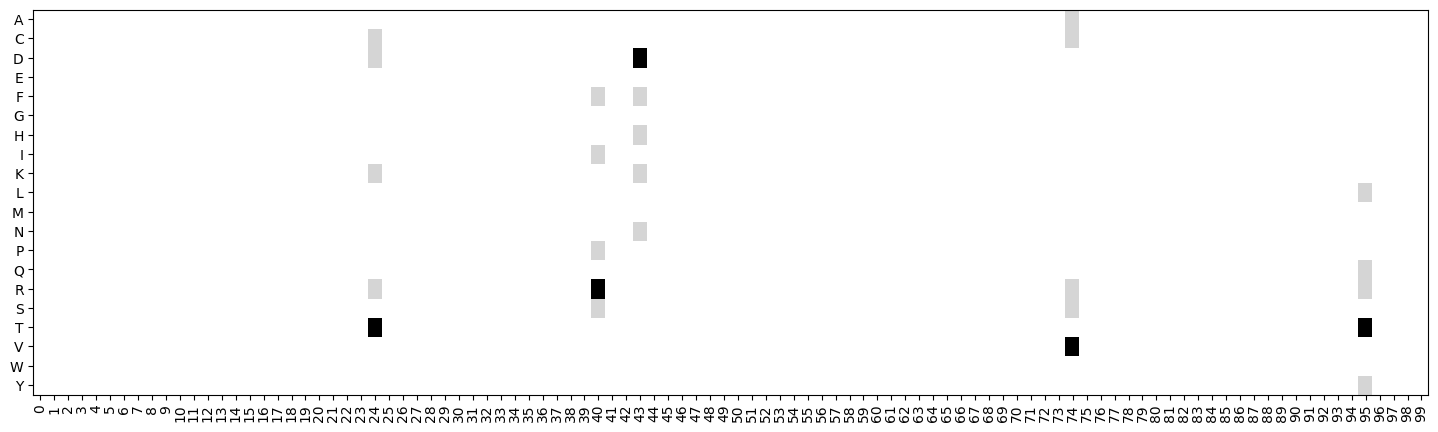

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's try to draw mutated sequences from this matrix 

Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentalist provided SOLD mat

In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(100)

In [5]:
seqs[0]

'RRDVT'

In [6]:
probs = S.compute_prob_n_mutations(num_mutated+1)

Text(0.5, 1.0, 'Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat')

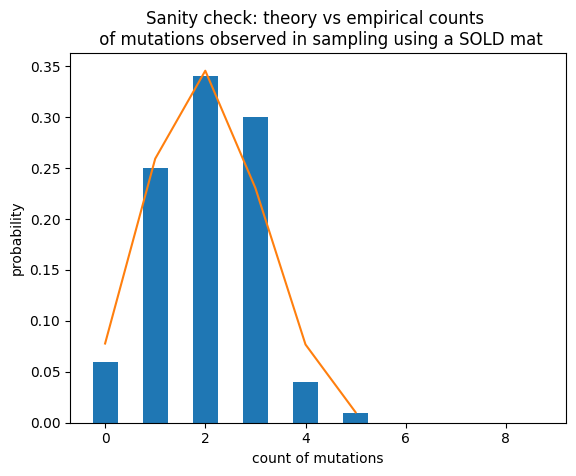

In [7]:
plt.hist(mutations, bins= np.array(range(10)) - 0.25, density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(probs)
plt.title("Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat")

# Now I need to provide weights to the independent and pairwise contributions

I create a mixture of pdfs to draw from, with a zero component (meaning not all independent and pairwise contributions have differential activity compared to parent, some have no effect, and one can control this effect size or model complexity in these simulations) 
Create a mixture of weigthts with random components and some sparse components 

In [8]:
I_params = {'rho':[0.20, 0.20], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
P_params = {'rho':[0.20, 0.20], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 


insilico_model = doe_utils.Create_in_silico_model(num_mutated, S.mutation_probs_variable_region_indexed, independent_params=I_params, pairwise_params=P_params)

In [9]:
test = doe_utils.Encoding_basics(num_mutated, S.mutation_probs_variable_region_indexed)


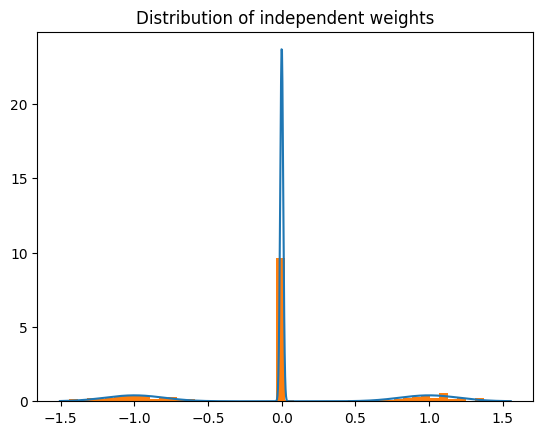

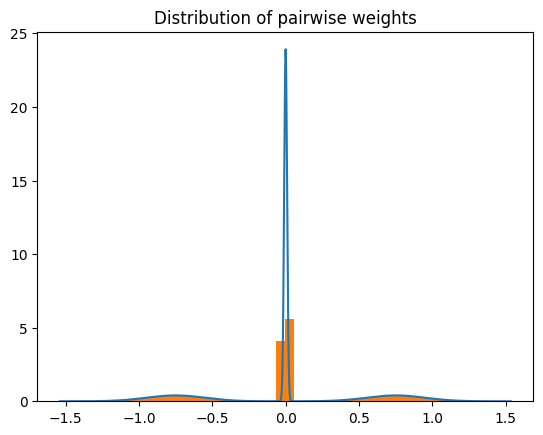

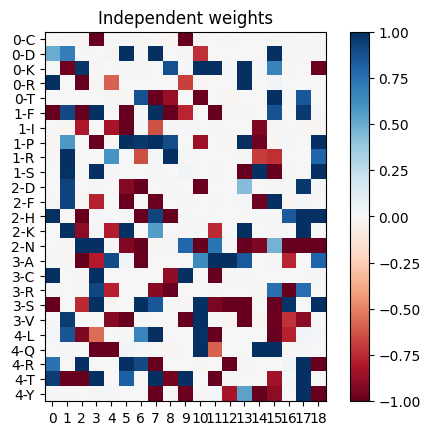

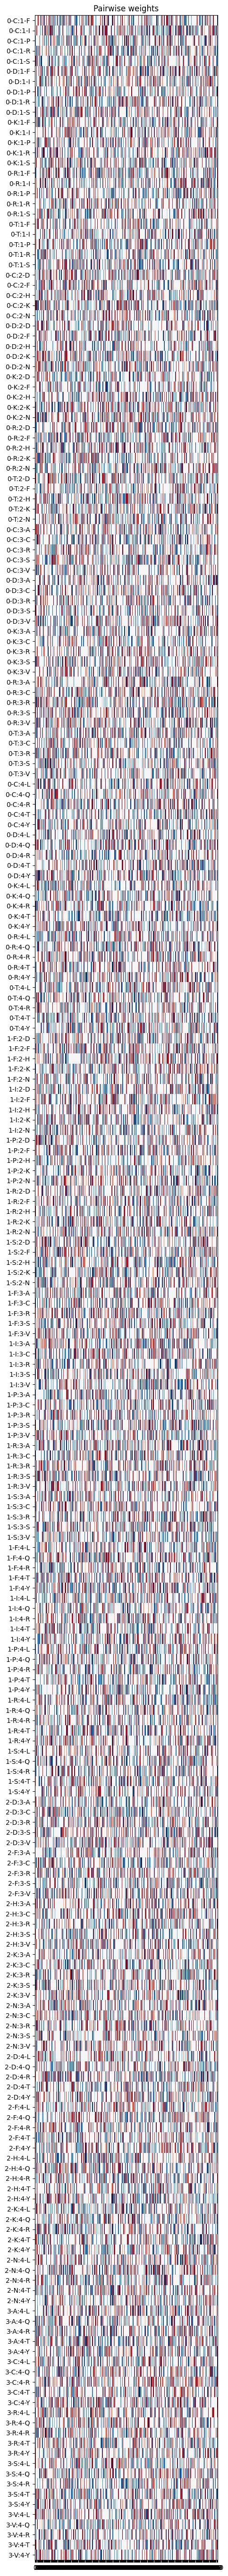

In [10]:
insilico_model.plot_weights()

In [11]:
# class Encoding_basics: 
#     """
#     Base class used by both ecnoders and in silico model 
#     """
#     def __init__(self, mutated_region_length, mutation_probs_variable_region_dict): 
#         """
#         Args: 
#             mutated region length: the number of positions mutated 
#             mutation_probs_variable_region_dict: the standard way to encode the mutations --- see notes and guide 
#         """
#         self.mutated_region_length = mutated_region_length 
#         assert len(mutation_probs_variable_region_dict) == self.mutated_region_length, "The dict passed is invalid, length mismatch" 
#         self.mutation_probs_variable_region_dict = mutation_probs_variable_region_dict
        
#         self.amino_product = [''.join(x) for x in product(AMINO_ACIDS, AMINO_ACIDS)]
#         self.pos_product = [np.asarray(x) for x in combinations(np.arange(mutated_region_length), 2)]

#         # Now I need to create the codes for the amino acids, using Hadamard matrix, drom the first column which is constant 
#         self.single_base_codes = H_20[:, 1:] # these are the codes for AMINO_ACIDS  
#         self.pairwise_base_codes = np.kron(self.single_base_codes, self.single_base_codes) # for AMINO_ACID pairs
        
#         # Notice that order in maintained in itertools.product and np.kron --- I checked--- this double_base_code_mat should now be assigned to the products 
#         # This is truly how we genralize to other interaction combinations 

#         # Now I need to collect all of this in codes for every position that actually appear in the SOLD libraries, 
#         # so I need to create positions by AMINO and postion_pairs by AMINO pairs matrices 
        
#         independent_codes = []
#         feature_names_independent = [] 
#         for k,v in mutation_probs_variable_region_dict.items(): 
#             for s,t in v.items(): 
#                 amino_index = AMINO_ACIDS.index(s)
#                 feature_names_independent.append(str(k) + '-' + str(s)) 
#                 independent_codes.append(self.single_base_codes[amino_index, :]) 

#         pairwise_codes = [] 
#         feature_names_pairwise = [] 
#         for i, a in enumerate(self.amino_product): 
#             for j, k in enumerate(self.pos_product): 
#                 if (a[0] in mutation_probs_variable_region_dict[k[0]]) &  (a[1] in mutation_probs_variable_region_dict[k[1]]): 
#                     amino_index = self.amino_product.index(''.join(a)) 
#                     feature_names_pairwise.append(str(k[0]) + '-' + str(a[0]) + ':' + str(k[1]) + '-' + str(a[1]))
#                     pairwise_codes.append(self.pairwise_base_codes[amino_index, :])
        
#         self.independent_codes = np.asarray(independent_codes) 
#         self.shape_independent_weights  = np.shape(self.independent_codes)
#         self.feature_names_independent = np.asarray(feature_names_independent) 
#         self.feature_names_pairwise = np.asarray(feature_names_pairwise)
#         self.pairwise_codes = np.asarray(pairwise_codes) 
#         self.shape_pairwise_weights  = np.shape(self.pairwise_codes) 
#         self.independent_mapper = {i:j for i,j in zip(self.feature_names_independent, self.independent_codes)}
#         self.pairwise_mapper = {i:j for i,j in zip(self.feature_names_pairwise, self.pairwise_codes)}

# Now compute respose for a bunch of seqs

Need to eocnde the sequeces into pairwise and independent features 


In [13]:
from doe_utils import H_20, Encoding_basics



class Sequence_encoder_simplex(Encoding_basics): 
    """
    Encodes sequence in simplex encodings --- this one doesn't try to create a general encoder but a SOLD library specifci encoder, which makes more sense anyway 
    Why encode variations / mutations you will never encounter? 
    """
    def __init__(self, mutated_region_length, mutation_probs_variable_region_dict): 
        """
        Args:
            mutated_region_length: the length of ONLY the variable region (mutated region) of the protein, NOT the whole protein length! 
        """
        super().__init__(mutated_region_length, mutation_probs_variable_region_dict) 
        
    def encode_seqs(self, protein_seqs): 
        """
        Args: 
            protein_seqs: this is only the variable region 
        """
        independent_codes = [] 
        pairwise_codes = [] 
        for seq in protein_seqs:
            array_of_seq = np.asarray(list(seq))
            assert len(seq) == self.mutated_region_length, "length mismatch of protein seq and attributes"
            
            local_code_I = np.zeros(self.shape_independent_weights)
            for i in range(self.mutated_region_length): 
                feature = str(i) + '-' + array_of_seq[i] 
                index = list(self.feature_names_independent).index(feature) 
                local_code_I[index, :] = self.independent_codes[index, :] 
            independent_codes.append(local_code_I)
            
            local_code_J = np.zeros(self.shape_pairwise_weights)
            for j, pos in enumerate(self.pos_product): 
                # need to find the index of amino_acid pairs 
                acid_pairs = array_of_seq[pos]
                feature = str(pos[0]) + '-' + acid_pairs[0] + ':' + str(pos[1]) + '-' + acid_pairs[1]
                index = list(self.feature_names_pairwise).index(feature)
                local_code_J[index, :] = self.pairwise_codes[index, :]
            pairwise_codes.append(local_code_J) 
            
        independent_codes = np.asarray(independent_codes)
        pairwise_codes = np.asarray(pairwise_codes)

        return independent_codes, pairwise_codes


In [14]:
seqs

['RRDVT',
 'TRDAY',
 'KRDVT',
 'TPNVT',
 'TRHCT',
 'DRKAT',
 'TPDCR',
 'DRDVQ',
 'DPDVT',
 'TFDVQ',
 'TINCT',
 'CRKVT',
 'TRDVY',
 'KPDCL',
 'TSDVY',
 'CFDVT',
 'TRDCY',
 'TRHVT',
 'DRNVT',
 'TRDVR',
 'KIDVT',
 'RRDVT',
 'DFDAT',
 'DFDVT',
 'TSDCY',
 'TSKRT',
 'KPKVT',
 'TRFVT',
 'KIDVT',
 'TFKVT',
 'TRDAT',
 'TRDSL',
 'RRNVY',
 'DPDVQ',
 'DRFVY',
 'TIDRT',
 'RRDVT',
 'KRDVR',
 'DSDVQ',
 'KIDAT',
 'TSDVT',
 'CPDSR',
 'TRNAT',
 'TRNVT',
 'TRDVY',
 'DPFVT',
 'TRDVT',
 'DRDRQ',
 'TRDVT',
 'TRDAR',
 'TSHVY',
 'KIKCR',
 'TRKCT',
 'TRDVT',
 'TIDVQ',
 'RRFVR',
 'RSDCR',
 'TRDVL',
 'CRDVR',
 'CSFVT',
 'TSDVT',
 'TRNAR',
 'TSFVQ',
 'TFDVT',
 'KPNVT',
 'TRDCT',
 'RRKVT',
 'TRNVR',
 'TRDVY',
 'TRDVT',
 'RSDVY',
 'TRKVQ',
 'DIDCT',
 'TRDRT',
 'TRHVL',
 'RRHST',
 'CSDVT',
 'TPHVT',
 'RRHST',
 'KRDRR',
 'CSDVT',
 'RSDVQ',
 'TRDVT',
 'RRHAL',
 'TPDVT',
 'TIDSY',
 'TRDVR',
 'RRDVL',
 'TIHVT',
 'DRDVT',
 'TRDVL',
 'KIDVT',
 'DRHVY',
 'KRDVT',
 'TIDCL',
 'TRNRR',
 'TIDST',
 'TRDVT',
 'TPDVT',
 'TIDVT']

In [15]:
Encoder = Sequence_encoder_simplex(num_mutated, S.mutation_probs_variable_region_indexed)
indp, pair = Encoder.encode_seqs(seqs) 

In [16]:
def plot_encoding_independent(Encoder, code_mat, seq):
    """
    simple plotting to check 
    """
    plt.figure() 
    plt.imshow(code_mat, vmin = -1, vmax = 1, interpolation = 'None', aspect = 'auto', cmap = 'RdBu') 
    _ = plt.yticks(range(len(Encoder.feature_names_independent)), Encoder.feature_names_independent)
    _ = plt.xticks(range(Encoder.shape_independent_weights[1]))
    plt.title(seq)
    plt.xlabel('weights for simplex encoding') 

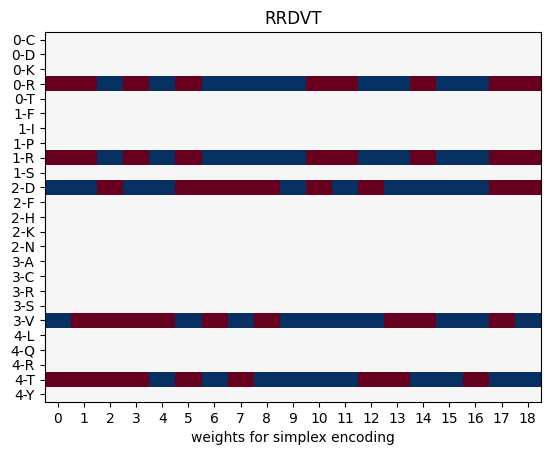

In [17]:
plot_encoding_independent(Encoder, indp[0], seqs[0])

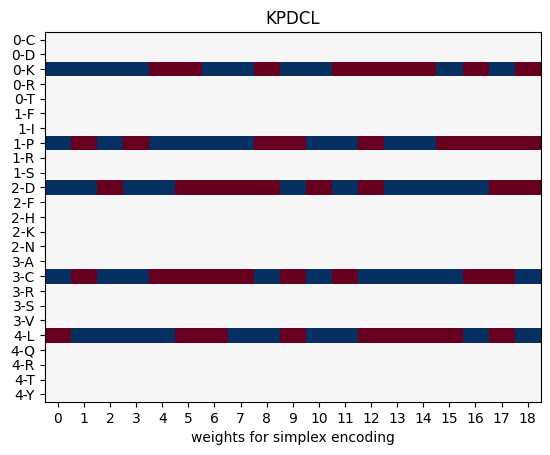

In [18]:
plot_encoding_independent(Encoder, indp[13], seqs[13])

In [19]:
def plot_encoding_pairwise(Encoder, code_mat, seq):
    """
    simple plotting to check 
    """
    plt.figure(figsize = (10, 70)) 
    plt.imshow(code_mat, vmin = -1, vmax = 1, interpolation = 'None', aspect = 'auto', cmap = 'RdBu') 
    _ = plt.yticks(range(len(Encoder.feature_names_pairwise)), Encoder.feature_names_pairwise)
    _ = plt.xticks(range(Encoder.shape_pairwise_weights[1]))
    plt.title(seq)
    plt.xlabel('weights for simplex encoding') 

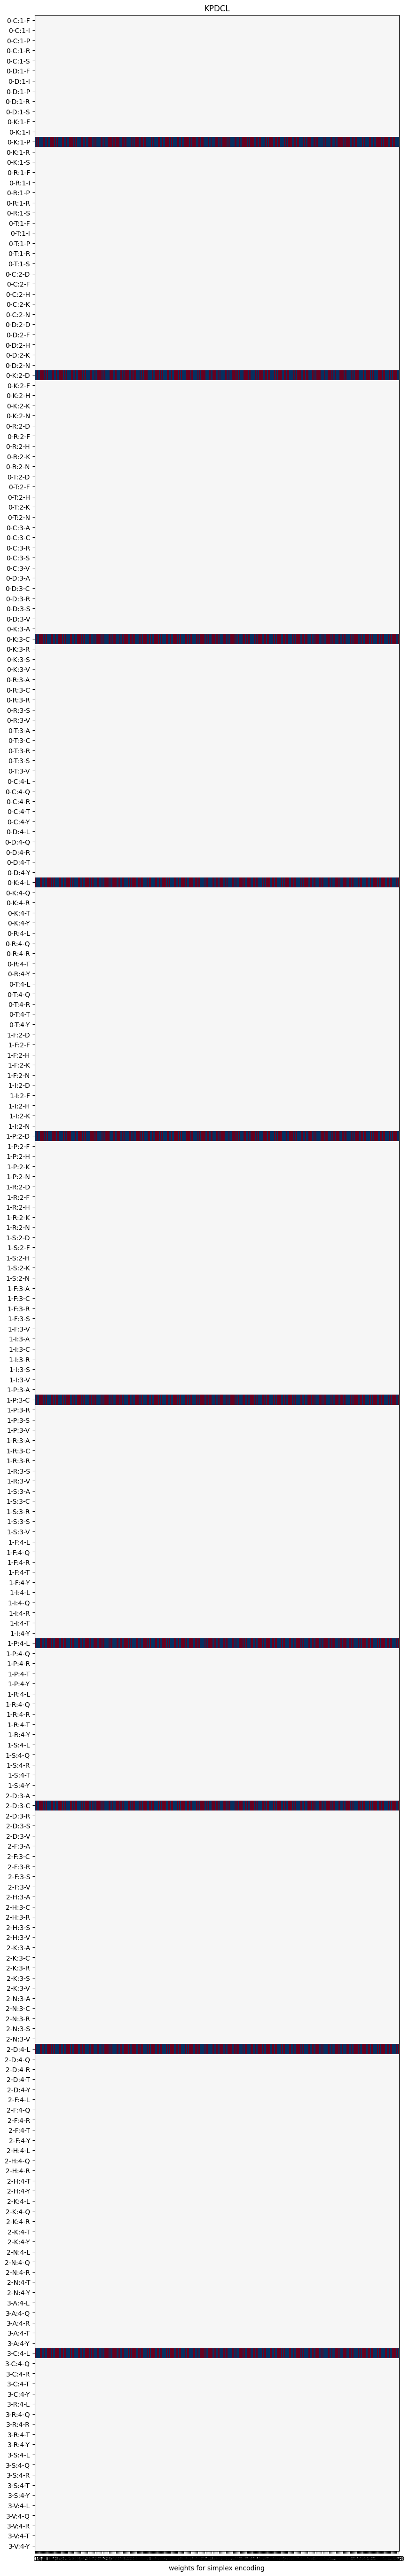

In [20]:
plot_encoding_pairwise(Encoder, pair[13], seqs[13])

# ENCODE

In [ ]:
Encoder = doe_utils.sequence_encoder(num_mutated)
encodings = Encoder.encode_seqs(seqs) # this produces two lists --- the first 1 is the independent encodings, the second one is pairwise encodings 

In [ ]:
responses = Model_in_silico.model(encodings[0], encodings[1], masked= True) 

In [ ]:
_ = plt.hist(responses, bins = 25)
plt.title("in silico responses (indel activity)") 

# Now do sparse (elastic net) linear regression to learn back the weights 

In [ ]:
fit_model = doe_utils.fitting_model(S.mutation_probs_variable_region_indexed)
fitted_params, fit_responses = fit_model.fit(seqs, responses)

plt.figure() 
plt.imshow(fit_model.constraints, aspect = 'auto', cmap = 'Greys', interpolation = 'None') 
plt.figure() 
plt.scatter(Model_in_silico.ground_truth_params, fitted_params)
plt.xlabel("ground truth") 
plt.ylabel("fitted params") 



In [ ]:
np.sum(Model_in_silico.pairwise_weights, axis =1)

In [ ]:
import scipy 

plt.plot(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)))

plt.title('Null space problem, we have zero eigenvalues in feature matrix')
plt.yscale('log')

In [ ]:
plt.scatter(fitted_params[fit_model.pairwise_indices], Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask])
plt.title('Pairwise params') 

In [ ]:
a,b  = doe_utils._create_zero_mean_pairwise_weights(Model_in_silico.pairwise_weights[Model_in_silico.pairwise_mask], Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)
c,d = doe_utils._create_zero_mean_pairwise_weights(fitted_params[fit_model.pairwise_indices], Model_in_silico.feature_names_pairwise, Model_in_silico.feature_names_independent)

In [ ]:
plt.plot(b)
plt.plot(d)

In [ ]:
d

In [ ]:
plt.scatter(fitted_params[fit_model.independent_indices], Model_in_silico.independent_weights[Model_in_silico.independent_mask])
plt.title('independent params')

In [ ]:
plt.plot(fit_responses, responses)

In [ ]:
np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001)

In [ ]:
print("Cant account for ... ") 

np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001) -np.shape(fit_model.constraints)[0]

In [ ]:
np.shape(Model_in_silico.pairwise_weights)

In [ ]:
np.shape(fit_model.constraints)

In [ ]:
np.shape(fit_model.independent_indices)

In [ ]:
np.shape(fit_model.pairwise_indices)

In [ ]:
import re

A = np.asarray([re.split(':' + "|" + '-', a) for a in Model_in_silico.feature_names_pairwise]) 

collector = [] 
for a in A: 
    if a[1] != a[3]:
        collector.append(a)
    

In [ ]:
np.shape(fit_model.independent_indices)

In [ ]:
ij = [a+b for a,b in zip(A[:,1],A[:,3])]
len(np.unique(ij))

In [ ]:
np.unique([[a,b] for a,b in zip(A[:,0], A[:,2])], axis = 0)

In [ ]:
A[:, [0, 2]]

In [ ]:
inds = np.all(A[:, [0,2]] == ['0', '1'], axis = 1)
inds

In [ ]:
A[inds]

In [ ]:

plt.figure(figsize = (5, 70))
plt.imshow(encodings[1][0], aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 1, cmap = 'Greys')
_  = plt.xticks(range(len(Encoder.pos_product)), Encoder.pos_product, rotation = 90)
_  = plt.yticks(range(len(Encoder.amino_product)), Encoder.amino_product)
plt.title(seqs[0]) 

In [ ]:
plt.imshow(encodings[0][0])

In [ ]:
np.max([1,2,3])